In [68]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
import matplotlib
import matplotlib.pyplot as plt
from d2l import torch as d2l
import time
from IPython import display

In [39]:
#展示一下fashionMnist数据集
d2l.use_svg_display()

In [40]:
trans=transforms.ToTensor()
train_dataset=torchvision.datasets.FashionMNIST(root="C:/Users/Administrator/Desktop/datasets/fashionMnist_download",train=True,transform=trans,download=True)
test_dataset=torchvision.datasets.FashionMNIST(root="C:/Users/Administrator/Desktop/datasets/fashionMnist_download",train=False,transform=trans,download=True)

In [41]:
len(train_dataset),len(test_dataset)

(60000, 10000)

In [42]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

In [43]:
image,label=train_dataset[0] #train_dataset每个元素都是一个元组，这个元组第一个元素是iamge，第二个元素是标签
print(image.size())
print(label)

torch.Size([1, 28, 28])
9


In [44]:
#定义两个可视化数据集的函数
def get_fashion_mnist_labels(labels):
    text_labels=['t-shirt','trouser','pullover','dress','coat','sandal','shirt','sneaker','bag','ankle boot']
    return [text_labels[int(i)] for i in labels]
def show_imgs(imgs,num_rows,num_cols,title=None,scale=1.5):
    figsize=(num_cols*scale,num_rows*scale) #注意长度是第一个数，宽度是第二个数 figsize=(长度，宽度)
    fig,axes=d2l.plt.subplots(num_rows,num_cols,figsize=figsize)
    axes=axes.flatten()
    for i, (ax,img) in enumerate(zip(axes,imgs)):
        ax.set_title(title[i])
        if torch.is_tensor(img):
            ax.imshow(img.numpy())
            ax.axis('off') #不显示坐标轴
        else:
            ax.imshow(img)
            ax.axis('off') #不显示坐标轴
    fig.tight_layout()

In [45]:
iter(data.DataLoader(train_dataset,batch_size=18))

In [46]:
X,y=next(iter(data.DataLoader(train_dataset,batch_size=18)))[0],next(iter(data.DataLoader(train_dataset,batch_size=18)))[1]

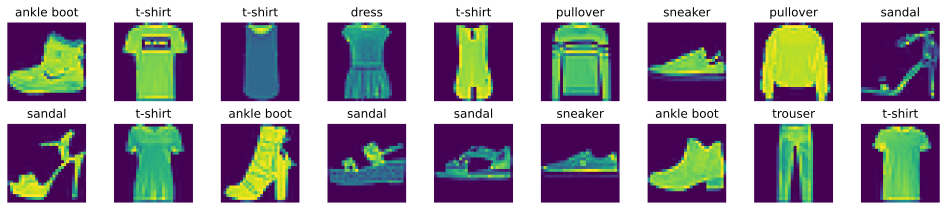

In [47]:
show_imgs(X.reshape(18,28,28),2,9,title=get_fashion_mnist_labels(y))

In [48]:
#读取一个小批量的数据
batch_size=256
train_iter=data.DataLoader(train_dataset,batch_size,shuffle=True,num_workers=4)
start_time=time.time()
for X,y in train_iter:
    continue
end_time=time.time()
print('time:%.5f'%float(end_time-start_time))

time:3.06282


In [49]:
def get_num_workers():
    return 1

In [50]:
#将加载数据放在一个函数中
def load_data_fashion_mnist(batch_size,resize=None):
    if resize:
        trans=transforms.Compose([transforms.ToTensor(),transforms.Resize(resize)])
    else:
        trans=transforms.ToTensor()
    train_dataset=torchvision.datasets.FashionMNIST(root="C:/Users/Administrator/Desktop/datasets/fashionMnist_download",train=True,transform=trans,download=False)
    test_dataset=torchvision.datasets.FashionMNIST(root="C:/Users/Administrator/Desktop/datasets/fashionMnist_download",train=False,transform=trans,download=False)
    return data.DataLoader(train_dataset,batch_size,shuffle=True,num_workers=get_num_workers()),data.DataLoader(test_dataset,batch_size,shuffle=False,num_workers=get_num_workers())

# Softmax回归从0开始实现

In [51]:
#加载数据集
batch_size=256
train_iter,test_iter=load_data_fashion_mnist(batch_size)

In [52]:
#初始化W和b
num_inputs=784
num_outputs=10
W=torch.normal(0,0.01,size=(num_inputs,num_outputs),requires_grad=True)
b=torch.zeros(num_outputs,requires_grad=True)

In [53]:
#实现softmax，输入的是256x784的数据
def softmax(X):
    X_exp=torch.exp(X)
    partition=torch.sum(X_exp,dim=1,keepdim=True) #必须要keepdim否则不能用广播机制
    return X_exp/partition

In [54]:
#实现模型
def net(X):
    return softmax(torch.matmul(X.reshape(-1,W.shape[0]),W)+b)

In [55]:
#损失函数构建
#怎么将预测值拿出来
y=torch.tensor([0,2])
y_hat=torch.tensor([[0.1,0.3,0.5],[0.2,0.4,0.8]])
y_hat[range(y_hat.shape[0]),y]
#实现交叉熵损失
def loss(y_hat,y):
    return -torch.log(y_hat[range(y_hat.shape[0]),y])
loss(y_hat,y)

tensor([2.3026, 0.2231])

In [56]:
def accuracy(y_hat,y):
    if len(y_hat.shape)>1 and y_hat.shape[1]>1:
        y_hat=y_hat.argmax(axis=1)
    accuracy_num=(y_hat==y).sum()
    return accuracy_num.item()
accuracy(y_hat,y)/len(y)

0.5

In [57]:
"在n个变量上累加"
class Accumulator:
    def __init__(self,n):
        self.data=[0.0]*n
    def add(self,*args):
        self.data=[a+float(b) for a,b in zip(self.data,args)]
    def reset(self):
        self.data=[0.0]*(len(self.data))
    def __getitem__(self,idx): #在类中定义这个方法，直接可以通过对象[idx]访问元素
        return self.data[idx]

In [58]:
def evaluate_accuracy(net,iter_data):
    if isinstance(net,torch.nn.Module): #判断net是不是torch.nn.Module的一个实例,如果是则将模型设定为评估模式,关闭一些特定用于训练的功能
        net.eval()
    metric = Accumulator(2)   
    for X,y in iter_data:
        metric.add(accuracy(net(X),y),y.numel())
    return metric[0]/metric[1]

In [59]:
#定义一个更新函数
def updater_(params,lr,batch_size):
    with torch.no_grad():
        for param in params:
            param-=lr*param.grad/batch_size
            param.grad.zero_()
lr=0.1
def updater(batch_size):
    return d2l.sgd([W,b],lr,batch_size)

In [60]:
#训练函数
def train_epoch_ch3(net,train_iter,loss,updater):
    if isinstance(net,torch.nn.Module):
        net.train()
    metric=Accumulator(3) #一个记录损失,一个记录正确的个数,一个记录总个数
    for X,y in train_iter:
        y_hat=net(X)
        l=loss(y_hat,y)        
        if isinstance(updater,torch.optim.Optimizer):  #判断updater是否是torch.optim.Optimizer类实例化的对象
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(float(l)*len(y),accuracy(y_hat,y),y.numel())
        else:
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()),accuracy(y_hat,y),y.numel())
    return metric[0]/metric[2],metric[1]/metric[2]

In [61]:
#设置一个在动画中绘图的函数
class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        self.config_axes = lambda: d2l.set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts
    def add(self, x, y):
        if not hasattr(y, "__len__"): #如果y是单个数字的情况,转换为列表
            y = [y]
        n = len(y)
        if not hasattr(x,"__len__"):
            x=[x]*n
        if not self.X:
            self.X = [[] for _ in range(n)] 
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a,b) in enumerate(zip(x,y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)
    """
    参数解释：
    xlabel: x轴的标签。
    ylabel: y轴的标签。
    legend: 图例，可以是一个列表，表示不同曲线的标签。
    xlim: x轴的范围。
    ylim: y轴的范围。
    xscale: x轴的缩放类型，默认为线性。
    yscale: y轴的缩放类型，默认为线性。
    fmts: 各个曲线的格式（颜色和线型）。
    nrows: 图表的行数。
    ncols: 图表的列数。
    figsize: 图表的尺寸。
    """

In [62]:
#训练函数
def train_ch3(net,train_iter,test_iter,loss,num_epochs,updater):
    animator=Animator(xlabel='epoch',xlim=[1,num_epochs],ylim=[0.3,1],legend=['train loss','train acc','test acc'])
    for epoch in range(num_epochs):
        train_metrics=train_epoch_ch3(net,train_iter,loss,updater)
        test_acc=evaluate_accuracy(net,test_iter)
        animator.add(epoch+1,train_metrics+(test_acc,))
    train_loss,train_accuracy=train_metrics

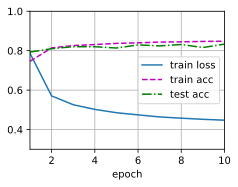

In [63]:
num_epochs = 10
train_ch3(net,train_iter,test_iter,loss,num_epochs,updater)

# 简洁实现

In [64]:
batch_size=256
train_iter,test_iter=d2l.load_data_fashion_mnist(batch_size)

In [65]:
net=torch.nn.Sequential(torch.nn.Flatten(),torch.nn.Linear(784,10))
def init_weights(m):
    if type(m)==torch.nn.Linear:
        torch.nn.init.normal_(m.weight,std=0.01)
net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

In [66]:
loss=torch.nn.CrossEntropyLoss()
updater=torch.optim.SGD(net.parameters(),lr=0.1)

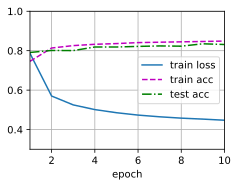

In [67]:
num_epochs=10
train_ch3(net,train_iter,test_iter,loss,num_epochs,updater)